This notebook contains all the code that needs to run to make use of pyCrepeK2

# Preprocessing

In [1]:
# imports
import pandas as pd
import numpy as np

In [2]:
# For this demonstration we will use the ag_news dataset.
# Here are some shell commands to untar our dataset
!pwd
!mkdir -p data/ag_news_csv
!tar -xvzf data/ag_news_csv.tar.gz -C data/ag_news_csv/
!mv data/ag_news_csv/ag_news_csv data/ag_news_csv/raw

/home/ubuntu/pyCrepeK2
ag_news_csv/
ag_news_csv/train.csv
ag_news_csv/test.csv
ag_news_csv/classes.txt
ag_news_csv/readme.txt
mv: cannot move 'data/ag_news_csv/ag_news_csv' to 'data/ag_news_csv/raw/ag_news_csv': Directory not empty


In [3]:
# Let's import the raw data and see how it looks
train_data = pd.read_csv('data/ag_news_csv/raw/train.csv', header=None)

In [4]:
train_data.head()

,0,1,2
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
# We can see that we have 3 columns, but our model only takes two columns, 
# X (containing the concatenation of subject + description)
# y (the class)
#
# So let's process both our training and test data to be in the right format.
train_data.columns = ['y', 'description', 'title']
train_data['X'] = train_data['description'] + " " + train_data['title']
train_data = train_data[['X','y']]

In [6]:
# We can also see the y-values go from 1-4.
set(train_data['y'].tolist())

{1, 2, 3, 4}

In [7]:
# We want them to go from 0-3
train_data['y'] = train_data['y'] - 1

In [8]:
train_data.head()

,X,y
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [9]:
# Training data looks right, so let's output it.
train_data.to_csv('data/ag_news_csv/train.csv', index=False)

In [10]:
# Now lets repeat the above for testing data
test_data = pd.read_csv('data/ag_news_csv/raw/test.csv', header=None)
test_data.columns = ['y', 'description', 'title']
test_data['X'] = test_data['description'] + " " + test_data['title']
test_data['y'] = test_data['y'] - 1
test_data = test_data[['X','y']]

In [11]:
test_data.head()

,X,y
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


In [12]:
# Again everything looks fine, so, let's write it out.
test_data.to_csv('data/ag_news_csv/test.csv', index=False)

# Running the Model

In [13]:
# Make sure you have the right Keras version (> 2.0)
import keras
keras.__version__

Using TensorFlow backend.


'2.0.4'

In [14]:
# Imports
from crepe import crepeK2

In [15]:
# Now we need to instantiate an object from our class
# We can optionally specify where to save the weights, but will just use the default
# The model expects validation data, but for purposes of this demonstration we'll just use test for validation
crepe = crepeK2(4, train_data_loc='data/ag_news_csv/train.csv', 
                val_data_loc='data/ag_news_csv/test.csv',
                test_data_loc='data/ag_news_csv/test.csv')

In [20]:
# Now we can fit our model, we use small batches and epochs to check its working
# When you run this properly, you should probably use a GPU or else be very patient.
crepe.fit(batch_size=100, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1008, 256)         122112    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 110, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 256)          196864    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 106, 256)          196864    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 104, 256)          196864    
__________

# Predict & Evaluate

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
eval_df = pd.read_csv('data/ag_news_csv/test.csv')

In [28]:
# From our evaluation DF extract an array containing our Y true values
y_true = np.asarray(eval_df['y'].tolist())

In [29]:
# Now use our model to obtain our prediction values
y_pred = crepe.predict(pred_data_loc='data/ag_news_csv/test.csv')

In [30]:
# Our predictions come in an array of probabilities, so we should convert this back into an ordinal format 
# by using the maximum probability as the decider
y_pred_ord = np.zeros(len(y_pred))
y_pred_ord[np.arange(len(y_pred))] = np.argmax(y_pred, axis=1)

/home/ubuntu/anaconda2/envs/py27k2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


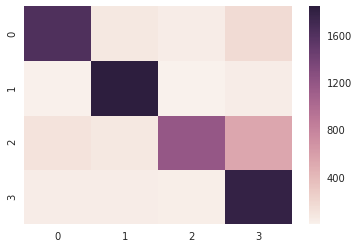

In [31]:
# Now we can use sklearn's handy functions to look at how well our model did
sns.heatmap(confusion_matrix(y_true, y_pred_ord))

In [32]:
print(classification_report(y_true, y_pred_ord))

             precision    recall  f1-score   support

          0       0.91      0.86      0.88      1900
          1       0.91      0.97      0.94      1900
          2       0.95      0.62      0.75      1900
          3       0.71      0.95      0.81      1900

avg / total       0.87      0.85      0.85      7600

